
**Importing necessary modules**

In [ ]:

from IPython.core.interactiveshell import InteractiveShell
import seaborn as sns
# PyTorch
from torchvision import transforms, datasets, models
import torch
from torch import optim, cuda
from torch.utils.data import DataLoader, sampler
import torch.nn as nn

import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

# Data science tools
import numpy as np
import pandas as pd
import os

# Image manipulations
from PIL import Image
# Useful for examining network
from torchsummary import summary
# Timing utility
from timeit import default_timer as timer

# Visualizations
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['font.size'] = 14

# Printing out all outputs
InteractiveShell.ast_node_interactivity = 'all'

**Defining the functions**

In [ ]:
def imshow(image):
    """Display image"""
    plt.figure(figsize=(6, 6))
    plt.imshow(image)
    plt.axis('off')
    plt.show()

In [ ]:
def imshow_tensor(image, ax=None, title=None):
    """Imshow for Tensor."""

    if ax is None:
        fig, ax = plt.subplots()


    image = image.numpy().transpose((1, 2, 0))

    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean

    image = np.clip(image, 0, 1)

    ax.imshow(image)
    plt.axis('off')

    return ax, image


In [ ]:
def get_pretrained_model(model_name):

    if model_name == 'vgg16':
        model = models.vgg16(pretrained=True)

        # Freeze early layers
        for param in model.parameters():
            param.requires_grad = False
        n_inputs = model.classifier[6].in_features

        # Add on classifier
        model.classifier[6] = nn.Sequential(
            nn.Linear(n_inputs, 256), nn.ReLU(), nn.Dropout(0.2),
            nn.Linear(256, n_classes), nn.LogSoftmax(dim=1))

    elif model_name == 'resnet50':
        model = models.resnet50(pretrained=True)

        for param in model.parameters():
            param.requires_grad = False

        n_inputs = model.fc.in_features
        model.fc = nn.Sequential(
            nn.Linear(n_inputs, 256), nn.ReLU(), nn.Dropout(0.2),
            nn.Linear(256, n_classes), nn.LogSoftmax(dim=1))

    if train_on_gpu:
        model = model.to('cuda')

    if multi_gpu:
        model = nn.DataParallel(model)

    return model

In [ ]:
def train(model,
          criterion,
          optimizer,
          train_loader,
          valid_loader,
          save_file_name,
          max_epochs_stop=3,
          n_epochs=20,
          print_every=2):

    epochs_no_improve = 0
    valid_loss_min = np.Inf

    valid_max_acc = 0
    history = []

    try:
        print(f'Model has been trained for: {model.epochs} epochs.\n')
    except:
        model.epochs = 0
        print(f'Starting Training from Scratch.\n')

    overall_start = timer()

    for epoch in range(n_epochs):


        train_loss = 0.0
        valid_loss = 0.0

        train_acc = 0
        valid_acc = 0

        model.train()
        start = timer()


        for ii, (data, target) in enumerate(train_loader):

            if train_on_gpu:
                data, target = data.cuda(), target.cuda()

            optimizer.zero_grad()
            output = model(data)

            loss = criterion(output, target)
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * data.size(0)

            _, pred = torch.max(output, dim=1)
            correct_tensor = pred.eq(target.data.view_as(pred))
            accuracy = torch.mean(correct_tensor.type(torch.FloatTensor))
            train_acc += accuracy.item() * data.size(0)

            print(
                f'Epoch: {epoch}\t{100 * (ii + 1) / len(train_loader):.2f}% complete. {timer() - start:.2f} seconds elapsed in epoch.',
                end='\r')

        else:
            model.epochs += 1

            with torch.no_grad():
                model.eval()

                for data, target in valid_loader:

                    if train_on_gpu:
                        data, target = data.cuda(), target.cuda()

                    output = model(data)

                    loss = criterion(output, target)
                    valid_loss += loss.item() * data.size(0)

                    _, pred = torch.max(output, dim=1)
                    correct_tensor = pred.eq(target.data.view_as(pred))
                    accuracy = torch.mean(
                        correct_tensor.type(torch.FloatTensor))
                    valid_acc += accuracy.item() * data.size(0)

                train_loss = train_loss / len(train_loader.dataset)
                valid_loss = valid_loss / len(valid_loader.dataset)

                train_acc = train_acc / len(train_loader.dataset)
                valid_acc = valid_acc / len(valid_loader.dataset)

                history.append([train_loss, valid_loss, train_acc, valid_acc])

                if (epoch + 1) % print_every == 0:
                    print(
                        f'\nEpoch: {epoch} \tTraining Loss: {train_loss:.4f} \tValidation Loss: {valid_loss:.4f}'
                    )
                    print(
                        f'\t\tTraining Accuracy: {100 * train_acc:.2f}%\t Validation Accuracy: {100 * valid_acc:.2f}%'
                    )

                if valid_loss < valid_loss_min:
                    torch.save(model.state_dict(), save_file_name)
                    epochs_no_improve = 0
                    valid_loss_min = valid_loss
                    valid_best_acc = valid_acc
                    best_epoch = epoch
                else:
                    epochs_no_improve += 1
                if epochs_no_improve >= max_epochs_stop:
                    print(
                        f'\nEarly Stopping! Total epochs: {epoch}. Best epoch: {best_epoch} with loss: {valid_loss_min:.2f} and acc: {100 * valid_acc:.2f}%'
                    )
                    total_time = timer() - overall_start
                    print(
                        f'{total_time:.2f} total seconds elapsed. {total_time / (epoch+1):.2f} seconds per epoch.'
                    )

                    model.load_state_dict(torch.load(save_file_name))
                    model.optimizer = optimizer


                    history = pd.DataFrame(
                        history,
                        columns=[
                            'train_loss', 'valid_loss', 'train_acc',
                            'valid_acc'
                        ])
                    return model, history


    model.optimizer = optimizer
    total_time = timer() - overall_start
    print(
        f'\nBest epoch: {best_epoch} with loss: {valid_loss_min:.2f} and acc: {100 * valid_acc:.2f}%'
    )

    history = pd.DataFrame(
        history,
        columns=['train_loss', 'valid_loss', 'train_acc', 'valid_acc'])
    return model, history


In [ ]:

def save_checkpoint(model, path):

    model_name = path.split('-')[0]
    assert (model_name in ['vgg16', 'resnet50'
                           ]), "Path must have the correct model name"

    # Basic details
    checkpoint = {
        'class_to_idx': model.class_to_idx,
        'idx_to_class': model.idx_to_class,
        'epochs': model.epochs,
    }

    if model_name == 'vgg16':
        if multi_gpu:
            checkpoint['classifier'] = model.module.classifier
            checkpoint['state_dict'] = model.module.state_dict()
        else:
            checkpoint['classifier'] = model.classifier
            checkpoint['state_dict'] = model.state_dict()

    elif model_name == 'resnet50':
        if multi_gpu:
            checkpoint['fc'] = model.module.fc
            checkpoint['state_dict'] = model.module.state_dict()
        else:
            checkpoint['fc'] = model.fc
            checkpoint['state_dict'] = model.state_dict()


    checkpoint['optimizer'] = model.optimizer
    checkpoint['optimizer_state_dict'] = model.optimizer.state_dict()

    torch.save(checkpoint, path)

In [ ]:
def load_checkpoint(path):

   model_name = path.split('-')[0]
    assert (model_name in ['vgg16', 'resnet50'
                           ]), "Path must have the correct model name"


    checkpoint = torch.load(path)

    if model_name == 'vgg16':
        model = models.vgg16(pretrained=True)

        for param in model.parameters():
            param.requires_grad = False
        model.classifier = checkpoint['classifier']

    elif model_name == 'resnet50':
        model = models.resnet50(pretrained=True)

        for param in model.parameters():
            param.requires_grad = False
        model.fc = checkpoint['fc']


    model.load_state_dict(checkpoint['state_dict'])

    total_params = sum(p.numel() for p in model.parameters())
    print(f'{total_params:,} total parameters.')
    total_trainable_params = sum(
        p.numel() for p in model.parameters() if p.requires_grad)
    print(f'{total_trainable_params:,} total gradient parameters.')


    if multi_gpu:
        model = nn.DataParallel(model)

    if train_on_gpu:
        model = model.to('cuda')


    model.class_to_idx = checkpoint['class_to_idx']
    model.idx_to_class = checkpoint['idx_to_class']
    model.epochs = checkpoint['epochs']


    optimizer = checkpoint['optimizer']
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

    return model, optimizer




In [ ]:
def process_image(image_path):
    """Process an image path into a PyTorch tensor"""

    image = Image.open(image_path)

    img = image.resize((256, 256))


    width = 256
    height = 256
    new_width = 224
    new_height = 224

    left = (width - new_width) / 2
    top = (height - new_height) / 2
    right = (width + new_width) / 2
    bottom = (height + new_height) / 2
    img = img.crop((left, top, right, bottom))

    img = np.array(img).transpose((2, 0, 1)) / 256

    means = np.array([0.485, 0.456, 0.406]).reshape((3, 1, 1))
    stds = np.array([0.229, 0.224, 0.225]).reshape((3, 1, 1))

    img = img - means
    img = img / stds

    img_tensor = torch.Tensor(img)

    return img_tensor

In [ ]:
def predict(image_path, model, topk=5):
    """Make a prediction for an image using a trained model

    Params
    --------
        image_path (str): filename of the image
        model (PyTorch model): trained model for inference
        topk (int): number of top predictions to return

    Returns

    """
    real_class = image_path.split('/')[-2]

    img_tensor = process_image(image_path)

    if train_on_gpu:
        img_tensor = img_tensor.view(1, 3, 224, 224).cuda()
    else:
        img_tensor = img_tensor.view(1, 3, 224, 224)


    with torch.no_grad():
        model.eval()
        out = model(img_tensor)
        ps = torch.exp(out)

        topk, topclass = ps.topk(topk, dim=1)

        top_classes = [
            model.idx_to_class[class_] for class_ in topclass.cpu().numpy()[0]
        ]
        top_p = topk.cpu().numpy()[0]

        return img_tensor.cpu().squeeze(), top_p, top_classes, real_class

In [ ]:
import numpy as np


np.random.seed = 100
def random_test_image():
    """Pick a random test image from the test directory"""
    c = np.random.choice(cat_df['category'])
    root = testdir + c + '/'
    img_path = root + np.random.choice(os.listdir(root))
    return img_path



In [ ]:
def display_prediction(image_path, model, topk):
    """Display image and preditions from model"""

    img, ps, classes, y_obs = predict(image_path, model, topk)
    result = pd.DataFrame({'p': ps}, index=classes)

    plt.figure(figsize=(16, 5))
    ax = plt.subplot(1, 2, 1)
    ax, img = imshow_tensor(img, ax=ax)

    ax.set_title(y_obs, size=20)

    ax = plt.subplot(1, 2, 2)
    result.sort_values('p')['p'].plot.barh(color='blue', edgecolor='k', ax=ax)
    plt.xlabel('Predicted Probability')
    plt.tight_layout()


In [ ]:
def accuracy(output, target, topk=(1, )):
    """Compute the topk accuracy(s)"""
    if train_on_gpu:
        output = output.to('cuda')
        target = target.to('cuda')

    with torch.no_grad():
        maxk = max(topk)
        batch_size = target.size(0)

        _, pred = output.topk(k=maxk, dim=1, largest=True, sorted=True)
        pred = pred.t()

        correct = pred.eq(target.view(1, -1).expand_as(pred))

        res = []

        for k in topk:
            correct_k = correct[:k].contiguous().view(-1).float().sum(0, keepdim=True)
            res.append(correct_k.mul_(100.0 / batch_size).item())
        return res


In [ ]:
def evaluate(model, test_loader, criterion, topk=(1, 5)):
    """Measure the performance of a trained PyTorch model

    Params
    --------
        model (PyTorch model): trained cnn for inference
        test_loader (PyTorch DataLoader): test dataloader
        topk (tuple of ints): accuracy to measure

    Returns
    --------
        results (DataFrame): results for each category

    """

    classes = []
    losses = []
    acc_results = np.zeros((len(test_loader.dataset), len(topk)))
    i = 0

    model.eval()
    with torch.no_grad():

        for data, targets in test_loader:

            if train_on_gpu:
                data, targets = data.to('cuda'), targets.to('cuda')

            out = model(data)
            for pred, true in zip(out, targets):
                acc_results[i, :] = accuracy(
                    pred.unsqueeze(0), true.unsqueeze(0), topk)
                classes.append(model.idx_to_class[true.item()])
                loss = criterion(pred.view(1, n_classes), true.view(1))
                losses.append(loss.item())
                i += 1

    results = pd.DataFrame(acc_results, columns=[f'top{i}' for i in topk])
    results['class'] = classes
    results['loss'] = losses
    results = results.groupby(classes).mean()

    return results.reset_index().rename(columns={'index': 'class'})

**Load dataset into notebook**

In [ ]:
data_dir= '/content/drive/MyDrive/aml_project/images_split/'
traindir = data_dir + 'train/'
validdir = data_dir + 'val/'
testdir = data_dir + 'test/'

batch_size = 32

In [ ]:
save_file_name_vgg16 = 'vgg16-transfer-4.pt'
checkpoint_path_vgg16 = 'vgg16-transfer-4.pth'

save_file_name_resnet50 = 'resnet50-transfer-4.pt'
checkpoint_path_resnet50 = 'resnet50-transfer-4.pth'



In [ ]:
train_on_gpu = cuda.is_available()
print(f'Train on gpu: {train_on_gpu}')

# Number of gpus
if train_on_gpu:
    gpu_count = cuda.device_count()
    print(f'{gpu_count} gpus detected.')
    if gpu_count > 1:
        multi_gpu = True
    else:
        multi_gpu = False

Train on gpu: True
1 gpus detected.


In [ ]:
categories = []
n_train = []
n_valid = []
n_test = []


for d in os.listdir(traindir):
    categories.append(d)


    train_imgs = os.listdir(traindir + d)
    valid_imgs = os.listdir(validdir + d)
    test_imgs = os.listdir(testdir + d)
    n_train.append(len(train_imgs))
    n_valid.append(len(valid_imgs))
    n_test.append(len(test_imgs))

cat_df = pd.DataFrame({'category': categories,
                       'n_train': n_train,
                       'n_valid': n_valid, 'n_test': n_test}).\
    sort_values('category')
cat_df.sort_values('n_train', ascending=False, inplace=True)
cat_df.head()

,category,n_train,n_valid,n_test
4,History,1278,159,161
1,"Health, Fitness & Dieting",1268,158,160
3,Religion & Spirituality,1261,157,159
2,Science & Math,1225,153,154
0,Arts & Photography,1189,148,150


In [ ]:
cpt = sum([len(files) for r, d, files in os.walk("/content/drive/MyDrive/aml_project/images_split/train")])
print(cpt)

6221


In [ ]:
image_transforms = {
    'train':
    transforms.Compose([
        transforms.RandomResizedCrop(size=256, scale=(0.8, 1.0)),
        transforms.RandomRotation(degrees=15),
        transforms.ColorJitter(),
        transforms.RandomHorizontalFlip(),
        transforms.CenterCrop(size=224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ]),

    'val':
    transforms.Compose([
        transforms.Resize(size=256),
        transforms.CenterCrop(size=224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),

    'test':
    transforms.Compose([
        transforms.Resize(size=256),
        transforms.CenterCrop(size=224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}


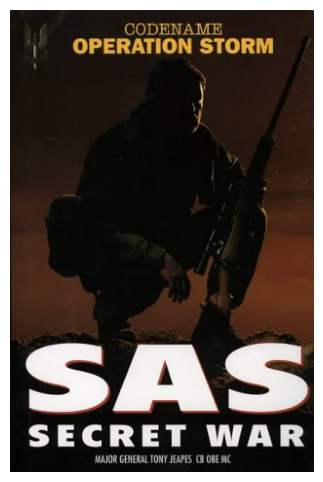

In [ ]:
ex_img = Image.open('/content/drive/MyDrive/aml_project/images_split/train/History/0004708997.jpg')
imshow(ex_img)

<Figure size 600x600 with 0 Axes>

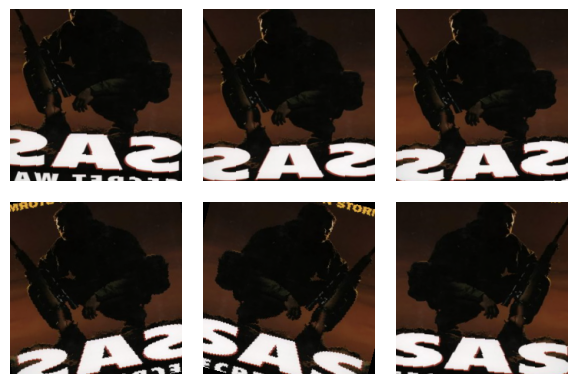

In [ ]:
t = image_transforms['train']
plt.figure(figsize=(6, 6))

for i in range(6):
    ax = plt.subplot(3, 3, i + 1)
    _ = imshow_tensor(t(ex_img), ax=ax)

plt.tight_layout()

In [ ]:
data = {
    'train':
    datasets.ImageFolder(root=traindir, transform=image_transforms['train']),
    'val':
    datasets.ImageFolder(root=validdir, transform=image_transforms['val']),
    'test':
    datasets.ImageFolder(root=testdir, transform=image_transforms['test'])
}

dataloaders = {
    'train': DataLoader(data['train'], batch_size=batch_size, shuffle=True),
    'val': DataLoader(data['val'], batch_size=batch_size, shuffle=True),
    'test': DataLoader(data['test'], batch_size=batch_size, shuffle=True)
}

In [ ]:
n_classes = len(cat_df)
print(f'There are {n_classes} different classes.')

len(data['train'].classes)



There are 5 different classes.


5

In [ ]:
trainiter = iter(dataloaders['train'])
features, labels = next(trainiter)
features.shape, labels.shape

(torch.Size([32, 3, 224, 224]), torch.Size([32]))

**Transfer Learning VGG16 model**

Approach The approach for using a pre-trained image recognition model is well-established:

1.   Load in pre-trained weights from a network trained on a large dataset
2.  Freeze all the weights in the lower (convolutional) layers

  * Layers to freeze can be adjusted depending on similarity of task to large training dataset
3.   Replace the classifier (fully connected) part of the network with a custom classifier

  * Number of outputs must be set equal to the number of classes

4. Train only the custom classifier (fully connected) layers for the task

  * Optimizer model classifier for smaller dataset






In [ ]:
model_VGG16 = models.vgg16(pretrained=True)
model_VGG16

/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [ ]:

# Freeze early layers
for param in model_VGG16.parameters():
    param.requires_grad = False


**Add on Custom Classifier **

We'll train a classifier consisting of the following layers

1.   Fully connected with ReLU activation (n_inputs, 256)
2.   Dropout with 40% chance of dropping

3.   Fully connected with log softmax output (256, n_classes)


To build our custom classifier, we use the nn.Sequential() module which allows us to specify each layer one after the other. We assign our custom classifier to the final classifier layer in the already trained vgg network. When we add on the extra layers, they are set to require_grad=True by default. These will be the only layers that are trained.

In [ ]:
n_inputs = model_VGG16.classifier[6].in_features

# Add on classifier
model_VGG16.classifier[6] = nn.Sequential(
    nn.Linear(n_inputs, 256), nn.ReLU(), nn.Dropout(0.4),
    nn.Linear(256, n_classes), nn.LogSoftmax(dim=1))

model_VGG16.classifier



Sequential(
  (0): Linear(in_features=25088, out_features=4096, bias=True)
  (1): ReLU(inplace=True)
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=4096, out_features=4096, bias=True)
  (4): ReLU(inplace=True)
  (5): Dropout(p=0.5, inplace=False)
  (6): Sequential(
    (0): Linear(in_features=4096, out_features=256, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.4, inplace=False)
    (3): Linear(in_features=256, out_features=5, bias=True)
    (4): LogSoftmax(dim=1)
  )
)

In [ ]:
total_params = sum(p.numel() for p in model_VGG16.parameters())
print(f'{total_params:,} total parameters.')
total_trainable_params = sum(
    p.numel() for p in model_VGG16.parameters() if p.requires_grad)
print(f'{total_trainable_params:,} training parameters.')


135,310,661 total parameters.
1,050,117 training parameters.


In [ ]:
if train_on_gpu:
    model_VGG16 = model_VGG16.to('cuda')

if multi_gpu:
    model_VGG16 = nn.DataParallel(model_VGG16)

In [ ]:
model_VGG16 = get_pretrained_model('vgg16')
if multi_gpu:
    summary(
        model_VGG16.module,
        input_size=(3, 224, 224),
        batch_size=batch_size,
        device='cuda')
else:
    summary(
        model_VGG16, input_size=(3, 224, 224), batch_size=batch_size, device='cuda')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [32, 64, 224, 224]           1,792
              ReLU-2         [32, 64, 224, 224]               0
            Conv2d-3         [32, 64, 224, 224]          36,928
              ReLU-4         [32, 64, 224, 224]               0
         MaxPool2d-5         [32, 64, 112, 112]               0
            Conv2d-6        [32, 128, 112, 112]          73,856
              ReLU-7        [32, 128, 112, 112]               0
            Conv2d-8        [32, 128, 112, 112]         147,584
              ReLU-9        [32, 128, 112, 112]               0
        MaxPool2d-10          [32, 128, 56, 56]               0
           Conv2d-11          [32, 256, 56, 56]         295,168
             ReLU-12          [32, 256, 56, 56]               0
           Conv2d-13          [32, 256, 56, 56]         590,080
             ReLU-14          [32, 256,

In [ ]:
if multi_gpu:
    print(model_VGG16.module.classifier[6])
else:
    print(model_VGG16.classifier[6])

Sequential(
  (0): Linear(in_features=4096, out_features=256, bias=True)
  (1): ReLU()
  (2): Dropout(p=0.2, inplace=False)
  (3): Linear(in_features=256, out_features=5, bias=True)
  (4): LogSoftmax(dim=1)
)


In [ ]:
model_VGG16.class_to_idx = data['train'].class_to_idx
model_VGG16.idx_to_class = {
    idx: class_
    for class_, idx in model_VGG16.class_to_idx.items()
}

list(model_VGG16.idx_to_class.items())[:10]


[(0, 'Arts & Photography'),
 (1, 'Health, Fitness & Dieting'),
 (2, 'History'),
 (3, 'Religion & Spirituality'),
 (4, 'Science & Math')]

Training Loss and Optimizer

*   Loss (criterion): keeps track of the loss itself and the gradients of the loss with respect to the model parameters (weights)
*   Optimizer: updates the parameters (weights) with the gradients







In [ ]:
criterion = nn.NLLLoss()
optimizer = optim.Adam(model_VGG16.parameters())



In [ ]:
for p in optimizer.param_groups[0]['params']:
    if p.requires_grad:
        print(p.shape)

torch.Size([256, 4096])
torch.Size([256])
torch.Size([5, 256])
torch.Size([5])


In [ ]:
model_trained_VGG16, history = train(
    model_VGG16,
    criterion,
    optimizer,
    dataloaders['train'],
    dataloaders['val'],
    save_file_name=save_file_name_vgg16,
    n_epochs=20,
    print_every=2)

Starting Training from Scratch.


Epoch: 1 	Training Loss: 1.3723 	Validation Loss: 1.3658
		Training Accuracy: 42.71%	 Validation Accuracy: 44.00%

Epoch: 3 	Training Loss: 1.3216 	Validation Loss: 1.3749
		Training Accuracy: 44.94%	 Validation Accuracy: 43.87%

Epoch: 5 	Training Loss: 1.2825 	Validation Loss: 1.3858
		Training Accuracy: 47.05%	 Validation Accuracy: 43.87%

Early Stopping! Total epochs: 5. Best epoch: 2 with loss: 1.35 and acc: 43.87%
553.97 total seconds elapsed. 92.33 seconds per epoch.


In [ ]:
model_trained_VGG16_3, history = train(
    model_trained_VGG16_2,
    criterion,
    optimizer,
    dataloaders['train'],
    dataloaders['val'],
    save_file_name=save_file_name_vgg16,
    n_epochs=5,
    print_every=1)

Model has been trained for: 16 epochs.


Epoch: 0 	Training Loss: 1.2477 	Validation Loss: 1.3932
		Training Accuracy: 48.79%	 Validation Accuracy: 42.84%

Epoch: 1 	Training Loss: 1.2364 	Validation Loss: 1.4153
		Training Accuracy: 49.46%	 Validation Accuracy: 41.29%

Epoch: 2 	Training Loss: 1.2224 	Validation Loss: 1.3816
		Training Accuracy: 49.91%	 Validation Accuracy: 44.26%

Epoch: 3 	Training Loss: 1.2038 	Validation Loss: 1.3774
		Training Accuracy: 51.68%	 Validation Accuracy: 45.03%

Epoch: 4 	Training Loss: 1.1924 	Validation Loss: 1.4018
		Training Accuracy: 51.92%	 Validation Accuracy: 44.00%

Best epoch: 3 with loss: 1.38 and acc: 44.00%


In [ ]:
torch.save(model_trained_VGG16_3,'/content/drive/MyDrive/aml_project/final models/vgg16_model.pt')

<Figure size 800x600 with 0 Axes>

Text(0.5, 0, 'Epoch')

Text(0, 0.5, 'Average Negative Log Likelihood')

Text(0.5, 1.0, 'Training and Validation Losses')

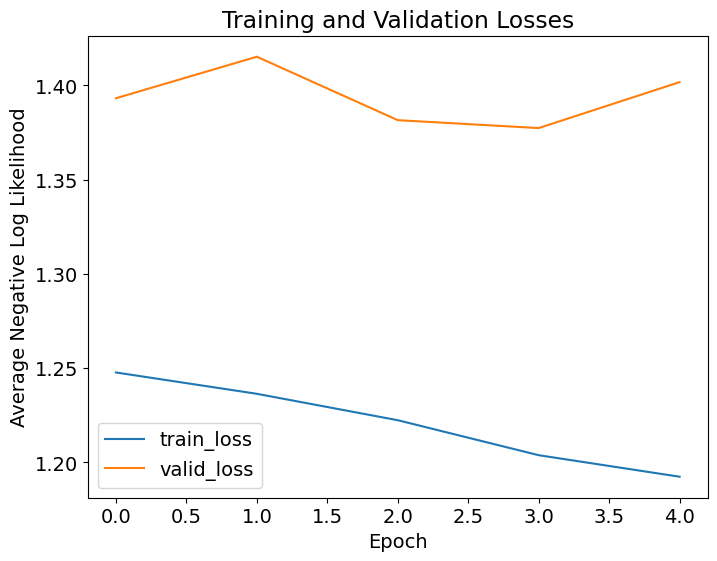

In [ ]:
plt.figure(figsize=(8, 6))
for c in ['train_loss', 'valid_loss']:
    plt.plot(
        history[c], label=c)
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Average Negative Log Likelihood')
plt.title('Training and Validation Losses')

<Figure size 800x600 with 0 Axes>

Text(0.5, 0, 'Epoch')

Text(0, 0.5, 'Average Accuracy')

Text(0.5, 1.0, 'Training and Validation Accuracy')

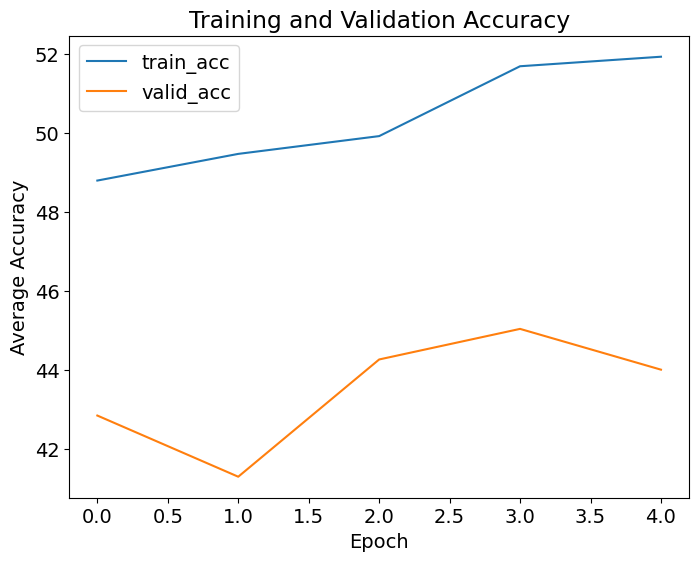

In [ ]:
# Draw accuracy
plt.figure(figsize=(8, 6))
for c in ['train_acc', 'valid_acc']:
    plt.plot(
        100 * history[c], label=c)
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Average Accuracy')
plt.title('Training and Validation Accuracy')



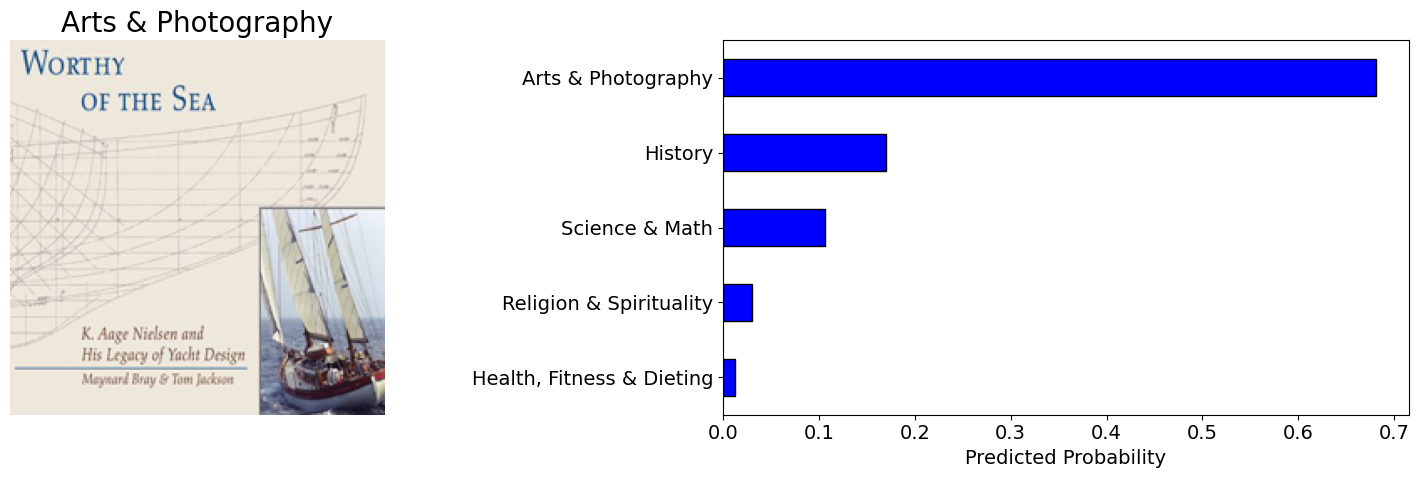

In [ ]:

# displays the picture along with the topk predictions from the model. The title over the image displays the true class
display_prediction(random_test_image(), model_trained_VGG16_3, topk=5)

In [ ]:
# accuracy for a prediction and a target in terms of topk.
testiter = iter(dataloaders['test'])
# Get a batch of testing images and labels
features, targets = next(testiter)

if train_on_gpu:
    accuracy(model_trained_VGG16_3(features.to('cuda')), targets)
else:
    accuracy(model_trained_VGG16_3(features), targets, topk=(1, 5))

[56.25]

In [ ]:
model_trained_resnet= torch.load('/content/drive/MyDrive/aml_project/resnet_20_epochs.pt')

In [ ]:
# accuracy for a prediction and a target in terms of topk.
testiter = iter(dataloaders['test'])
# Get a batch of testing images and labels
features, targets = next(testiter)

if train_on_gpu:
    accuracy(model_trained_resnet(features.to('cuda')), targets, topk=(1, 5))
else:
    accuracy(model_trained_resnet(features), targets, topk=(1, 5))

[37.5, 100.0]

In [ ]:
# iterate through the testing set in order to make predictions for each image and calculates performance for each category.
criterion = nn.NLLLoss()
# Evaluate the model on all the training data
results_VGG16 = evaluate(model_trained_VGG16_3, dataloaders['test'], criterion)
results_VGG16.head()

,class,top1,top5,loss
0,Arts & Photography,45.333333,100.0,1.337152
1,"Health, Fitness & Dieting",63.125000,100.0,1.189116
2,History,36.024845,100.0,1.366226
3,Religion & Spirituality,35.849057,100.0,1.518556
4,Science & Math,42.207792,100.0,1.627379


In [ ]:

# Load VGG16 model with pretrained weight
model_VGG19 = models.vgg19(pretrained=True)
model_VGG19

/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth
100%|██████████| 548M/548M [00:02<00:00, 209MB/s]


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

In [ ]:
# Freeze early layers
for param in model_VGG19.parameters():
    param.requires_grad = False

In [ ]:

n_inputs = model_VGG19.classifier[6].in_features

model_VGG19.classifier[6] = nn.Sequential(
    nn.Linear(n_inputs, 256), nn.ReLU(), nn.Dropout(0.4),
    nn.Linear(256, n_classes), nn.LogSoftmax(dim=1))

model_VGG19.classifier

Sequential(
  (0): Linear(in_features=25088, out_features=4096, bias=True)
  (1): ReLU(inplace=True)
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=4096, out_features=4096, bias=True)
  (4): ReLU(inplace=True)
  (5): Dropout(p=0.5, inplace=False)
  (6): Sequential(
    (0): Linear(in_features=4096, out_features=256, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.4, inplace=False)
    (3): Linear(in_features=256, out_features=5, bias=True)
    (4): LogSoftmax(dim=1)
  )
)

In [ ]:
total_params = sum(p.numel() for p in model_VGG19.parameters())
print(f'{total_params:,} total parameters.')
total_trainable_params = sum(
    p.numel() for p in model_VGG19.parameters() if p.requires_grad)
print(f'{total_trainable_params:,} training parameters.')


140,620,357 total parameters.
1,050,117 training parameters.


In [ ]:
if train_on_gpu:
    model_VGG19 = model_VGG19.to('cuda')

if multi_gpu:
    model_VGG19 = nn.DataParallel(model_VGG19)

In [ ]:
if multi_gpu:
    print(model_VGG19.module.classifier[6])
else:
    print(model_VGG19.classifier[6])

Sequential(
  (0): Linear(in_features=4096, out_features=256, bias=True)
  (1): ReLU()
  (2): Dropout(p=0.4, inplace=False)
  (3): Linear(in_features=256, out_features=5, bias=True)
  (4): LogSoftmax(dim=1)
)


In [ ]:
model_VGG19.class_to_idx = data['train'].class_to_idx
model_VGG19.idx_to_class = {
    idx: class_
    for class_, idx in model_VGG19.class_to_idx.items()
}

list(model_VGG19.idx_to_class.items())[:10]


[(0, 'Arts & Photography'),
 (1, 'Health, Fitness & Dieting'),
 (2, 'History'),
 (3, 'Religion & Spirituality'),
 (4, 'Science & Math')]

In [ ]:
criterion = nn.NLLLoss()
optimizer = optim.Adam(model_VGG19.parameters())

In [ ]:
for p in optimizer.param_groups[0]['params']:
    if p.requires_grad:
        print(p.shape)

torch.Size([256, 4096])
torch.Size([256])
torch.Size([5, 256])
torch.Size([5])


In [ ]:
model_trained_VGG19, history = train(
    model_VGG19,
    criterion,
    optimizer,
    dataloaders['train'],
    dataloaders['val'],
    save_file_name=save_file_name_vgg16,
    max_epochs_stop=25,
    n_epochs=20,
    print_every=2)

Starting Training from Scratch.


Epoch: 1 	Training Loss: 1.3868 	Validation Loss: 1.3759
		Training Accuracy: 41.58%	 Validation Accuracy: 42.19%

Epoch: 3 	Training Loss: 1.3505 	Validation Loss: 1.3527
		Training Accuracy: 43.64%	 Validation Accuracy: 44.52%

Epoch: 5 	Training Loss: 1.3152 	Validation Loss: 1.3519
		Training Accuracy: 44.72%	 Validation Accuracy: 43.74%

Epoch: 7 	Training Loss: 1.2952 	Validation Loss: 1.3595
		Training Accuracy: 44.83%	 Validation Accuracy: 44.13%

Epoch: 9 	Training Loss: 1.2823 	Validation Loss: 1.3708
		Training Accuracy: 47.13%	 Validation Accuracy: 43.61%

Epoch: 11 	Training Loss: 1.2646 	Validation Loss: 1.3922
		Training Accuracy: 48.34%	 Validation Accuracy: 42.19%

Epoch: 13 	Training Loss: 1.2523 	Validation Loss: 1.3799
		Training Accuracy: 48.30%	 Validation Accuracy: 43.23%

Epoch: 15 	Training Loss: 1.2289 	Validation Loss: 1.3818
		Training Accuracy: 49.78%	 Validation Accuracy: 44.00%

Epoch: 17 	Training Loss: 1.2090 	Validatio

In [ ]:
torch.save(model_trained_VGG19,'/content/drive/MyDrive/aml_project/final models/vgg_19_model.pt')

<Figure size 800x600 with 0 Axes>

Text(0.5, 0, 'Epoch')

Text(0, 0.5, 'Average Negative Log Likelihood')

Text(0.5, 1.0, 'Training and Validation Losses')

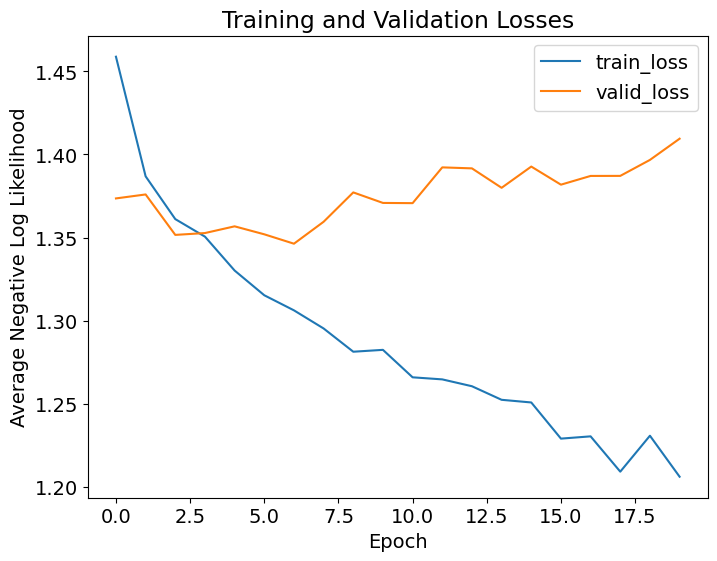

In [ ]:
plt.figure(figsize=(8, 6))
for c in ['train_loss', 'valid_loss']:
    plt.plot(
        history[c], label=c)
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Average Negative Log Likelihood')
plt.title('Training and Validation Losses')

<Figure size 800x600 with 0 Axes>

Text(0.5, 0, 'Epoch')

Text(0, 0.5, 'Average Accuracy')

Text(0.5, 1.0, 'Training and Validation Accuracy')

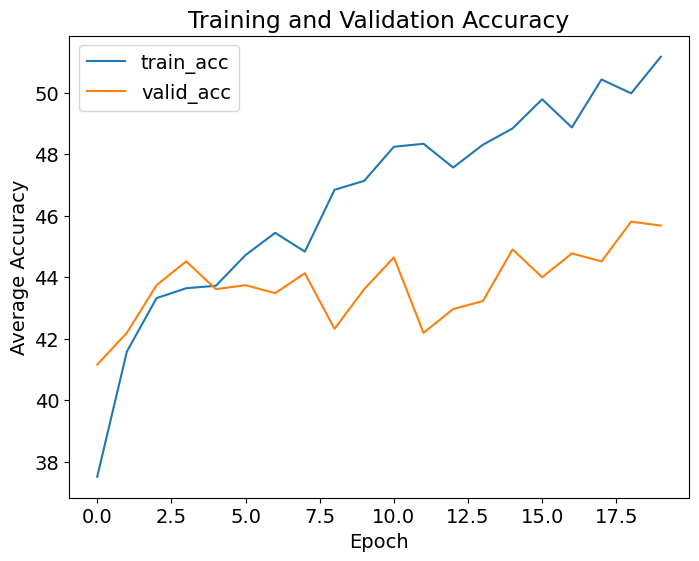

In [ ]:
# Draw accuracy
plt.figure(figsize=(8, 6))
for c in ['train_acc', 'valid_acc']:
    plt.plot(
        100 * history[c], label=c)
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Average Accuracy')
plt.title('Training and Validation Accuracy')



In [ ]:
testiter = iter(dataloaders['test'])
features, targets = next(testiter)

if train_on_gpu:
    accuracy(model_trained_VGG19(features.to('cuda')), targets, topk=(1, 5))
else:
    accuracy(model_trained_VGG19(features), targets, topk=(1, 5))

[50.0, 100.0]

In [ ]:
criterion = nn.NLLLoss()
results_VGG16 = evaluate(model_trained_VGG19, dataloaders['test'], criterion)
results_VGG16.head()

,class,top1,top5,loss
0,Arts & Photography,34.000000,100.0,1.534135
1,"Health, Fitness & Dieting",58.125000,100.0,1.087396
2,History,31.677019,100.0,1.721976
3,Religion & Spirituality,41.509434,100.0,1.443352
4,Science & Math,50.649351,100.0,1.446224


In [ ]:
model_ResNet50= models.resnet50(pretrained=True)
model_ResNet50

/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 203MB/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [ ]:

# Freeze early layers
for param in model_ResNet50.parameters():
    param.requires_grad = False


In [ ]:
total_params = sum(p.numel() for p in model_ResNet50.parameters())
print(f'{total_params:,} total parameters.')
total_trainable_params = sum(
    p.numel() for p in model_ResNet50.parameters() if p.requires_grad)
print(f'{total_trainable_params:,} training parameters.')

25,557,032 total parameters.
0 training parameters.


In [ ]:
if train_on_gpu:
    model_ResNet50 = model_ResNet50.to('cuda')

if multi_gpu:
    model_ResNet50 = nn.DataParallel(model_resnet)

In [ ]:
model_ResNet50 = get_pretrained_model('resnet50')
if multi_gpu:
    summary(
        model_ResNet50.module,
        input_size=(3, 224, 224),
        batch_size=batch_size,
        device='cuda')
else:
    summary(
        model_ResNet50, input_size=(3, 224, 224), batch_size=batch_size, device='cuda')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [32, 64, 112, 112]           9,408
       BatchNorm2d-2         [32, 64, 112, 112]             128
              ReLU-3         [32, 64, 112, 112]               0
         MaxPool2d-4           [32, 64, 56, 56]               0
            Conv2d-5           [32, 64, 56, 56]           4,096
       BatchNorm2d-6           [32, 64, 56, 56]             128
              ReLU-7           [32, 64, 56, 56]               0
            Conv2d-8           [32, 64, 56, 56]          36,864
       BatchNorm2d-9           [32, 64, 56, 56]             128
             ReLU-10           [32, 64, 56, 56]               0
           Conv2d-11          [32, 256, 56, 56]          16,384
      BatchNorm2d-12          [32, 256, 56, 56]             512
           Conv2d-13          [32, 256, 56, 56]          16,384
      BatchNorm2d-14          [32, 256,

In [ ]:
# To keep track of the predictions made by the model, we create a mapping of classes to indexes and indexes to classes.
# This will let us know the actual class for a given prediction.
model_ResNet50.class_to_idx = data['train'].class_to_idx
model_ResNet50.idx_to_class = {
    idx: class_
    for class_, idx in model_ResNet50.class_to_idx.items()
}

list(model_ResNet50.idx_to_class.items())[:10]

[(0, 'Arts & Photography'),
 (1, 'Health, Fitness & Dieting'),
 (2, 'History'),
 (3, 'Religion & Spirituality'),
 (4, 'Science & Math')]

In [ ]:
criterion = nn.NLLLoss()
optimizer = optim.Adam(model_ResNet50.parameters())

In [ ]:
for p in optimizer.param_groups[0]['params']:
    if p.requires_grad:
        print(p.shape)



torch.Size([256, 2048])
torch.Size([256])
torch.Size([5, 256])
torch.Size([5])


In [ ]:
model_trained_resnet, history = train(
    model_ResNet50,
    criterion,
    optimizer,
    dataloaders['train'],
    dataloaders['val'],
    save_file_name=save_file_name_resnet50,
    max_epochs_stop=25,
    n_epochs=20,
    print_every=2)



Model has been trained for: 7 epochs.


Epoch: 1 	Training Loss: 1.2895 	Validation Loss: 1.3401
		Training Accuracy: 46.91%	 Validation Accuracy: 43.74%

Epoch: 3 	Training Loss: 1.2774 	Validation Loss: 1.3738
		Training Accuracy: 47.77%	 Validation Accuracy: 42.45%

Epoch: 5 	Training Loss: 1.2737 	Validation Loss: 1.3607
		Training Accuracy: 47.05%	 Validation Accuracy: 44.90%

Epoch: 7 	Training Loss: 1.2527 	Validation Loss: 1.3456
		Training Accuracy: 48.87%	 Validation Accuracy: 46.19%

Epoch: 9 	Training Loss: 1.2470 	Validation Loss: 1.3733
		Training Accuracy: 49.46%	 Validation Accuracy: 44.13%

Epoch: 11 	Training Loss: 1.2312 	Validation Loss: 1.3637
		Training Accuracy: 49.91%	 Validation Accuracy: 44.77%

Epoch: 13 	Training Loss: 1.2245 	Validation Loss: 1.3787
		Training Accuracy: 49.37%	 Validation Accuracy: 42.97%

Epoch: 15 	Training Loss: 1.1991 	Validation Loss: 1.4168
		Training Accuracy: 50.47%	 Validation Accuracy: 42.45%

Epoch: 17 	Training Loss: 1.2106 	Val

In [ ]:
torch.save(model_trained_resnet,'/content/drive/MyDrive/aml_project/final models/resnet_model.pt')

<Figure size 800x600 with 0 Axes>

Text(0.5, 0, 'Epoch')

Text(0, 0.5, 'Average Negative Log Likelihood')

Text(0.5, 1.0, 'Training and Validation Losses')

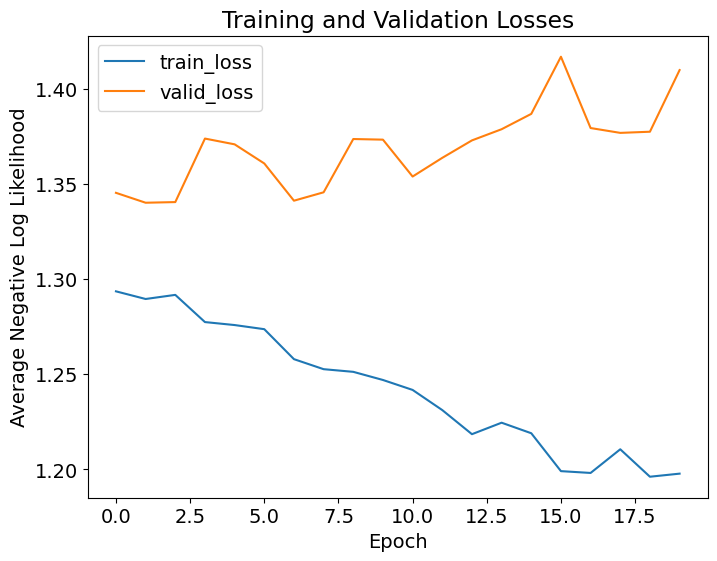

In [ ]:
plt.figure(figsize=(8, 6))
for c in ['train_loss', 'valid_loss']:
    plt.plot(
        history[c], label=c)
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Average Negative Log Likelihood')
plt.title('Training and Validation Losses')

<Figure size 800x600 with 0 Axes>

Text(0.5, 0, 'Epoch')

Text(0, 0.5, 'Average Accuracy')

Text(0.5, 1.0, 'Training and Validation Accuracy')

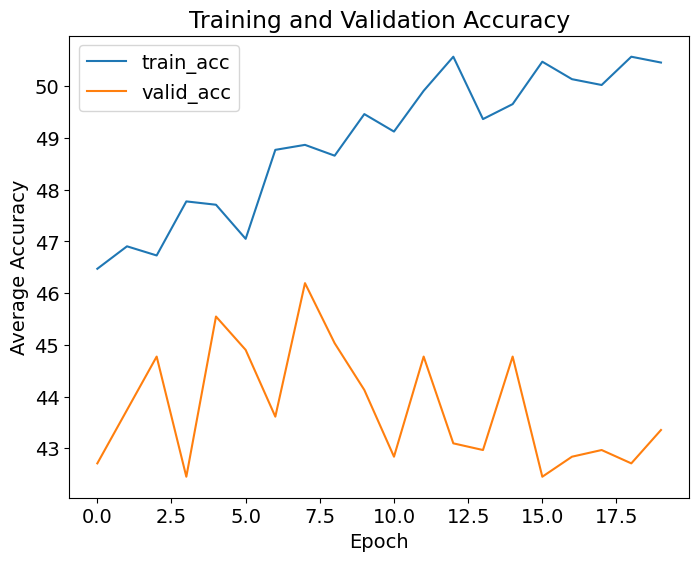

In [ ]:
# Draw accuracy
plt.figure(figsize=(8, 6))
for c in ['train_acc', 'valid_acc']:
    plt.plot(
        100 * history[c], label=c)
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Average Accuracy')
plt.title('Training and Validation Accuracy')



In [ ]:
# accuracy for a prediction and a target in terms of topk.
testiter = iter(dataloaders['test'])
# Get a batch of testing images and labels
features, targets = next(testiter)

if train_on_gpu:
    accuracy(model_trained_resnet(features.to('cuda')), targets, topk=(1, 5))
else:
    accuracy(model_trained_resnet(features), targets, topk=(1, 5))

[43.75, 100.0]

In [ ]:
# iterate through the testing set in order to make predictions for each image and calculates performance for each category.
criterion = nn.NLLLoss()
# Evaluate the model on all the training data
results_resnet = evaluate(model_trained_resnet, dataloaders['test'], criterion)
results_resnet.head()

,class,top1,top5,loss
0,Arts & Photography,44.666667,100.0,1.291533
1,"Health, Fitness & Dieting",54.375000,100.0,1.122493
2,History,33.540373,100.0,1.726921
3,Religion & Spirituality,31.446541,100.0,1.476960
4,Science & Math,54.545455,100.0,1.305337
